In [5]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from skimage.transform import resize
from sklearn import svm
import pickle
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
import seaborn as sns
from collections import Counter

In the code cell below, we load the image from the directory into a numpy array. We use Numpy here to make the computations and manipulations easier.
We use all 3 channels of the image and flatten the resulting array to give us a 2D matrix, which will be used to compute and work with the pixel values of each image.
We did not choose to grayscale the image since the gradients and HOG features were not significantly raising the accuracy  (accuracy was 50% = guessing). We therefore decided to just use the pixel values of each image for classification.
This is all of the preprocessing conducted.

In [2]:
dataset = []

filepath = "DCTrain/"
#Total classes = 2
labels = ['dog','cat']
for label in labels:
  path = os.path.join(filepath, label)
  tr_class = labels.index(label)
  for image in os.listdir(path):
    img_path = os.path.join(path,image)
    img = cv2.imread(img_path,0)
    try:
      img = resize(img, (50,50))
      sample = np.array(img).flatten()
      dataset.append([sample, tr_class])
    except Exception as e:
      pass

input = open('training.pickle','wb')
pickle.dump(dataset, input)
input.close()

In [3]:
#Load features (pixel values) from the permanently stored pickle file into an array
#Load the labels into a separate array
out = open('training.pickle','rb')
training_data = pickle.load(out)
out.close()
np.random.shuffle(training_data)
features = []
labels = []

for feat, lab in training_data:
    features.append(feat)
    labels.append(lab)



There are 8000 training images of both dogs and cats combined. We shuffle the images after loading them from a pickle file (for faster computation), so that there is no bias or irregular distribution of the features in the feature space, in this case, the pixel values.
Flattening out the images and combining all the features gives us a total of 2500 features.

In [7]:
#Number of total pixel values, which are the features.
print("Total # of training samples: ",np.array(features).shape)

#Number of labels
print("Total # of training labels: ", np.array(labels).shape)

label_counts = Counter(labels)

# Number of samples for each class
for label, count in label_counts.items():
    if label == 0:
        lab = 'dog'
    if label == 1:
        lab = 'cat'
    print(f"Class '{lab}' has {count} samples.")

Total # of training samples:  (8005, 2500)
Total # of training labels:  (8005,)
Class 'dog' has 4005 samples.
Class 'cat' has 4000 samples.


In the following code cell, we train our SVM classifier with a polynomial kernel.
We use the polynomial kernel so that we can experiment and capture any non linear relationships between the pixel values, leading to multiple features.
This is because the HOG features, the gradients, and even computing the Canny edges of the images did not provide accurate results. We therefore thought that the pixel values might have a more complex relationship with each other, especially near the areas of the faces of the animals, that the previous features could not capture.
We use the value of C = 10 for the bias coefficient (1/B) after experimenting with different C values in the range [0.1,1,10,100] using K fold cross validation.
This is not visible in the code since computing and printing the results of the K fold CV took an arbitrarily large amount of time (around 2-3 hours) and after the results, we came across an error which had to be fixed.

In [8]:
#Initialize the classifier
#Perform a grid search Cross Validation for the best gamma value for regularization.
gamma = [0.001, 0.01, 0.1, 1, 10, 100]


#Train on the first gamma value
SVM = SVC(C=10, kernel='poly', gamma=0.001)
SVM.fit(features, labels)





SVC(C=10, gamma=0.001, kernel='poly')

We train our model using different gamma values to experiment which value gives the best accuracy with the test data.

In [9]:
#Train on the second gamma value
SVM2 = SVC(C=10, kernel='poly', gamma=0.01)
SVM2.fit(features, labels)

SVC(C=10, gamma=0.01, kernel='poly')

In [10]:
#Train on the 3rd gamma value
SVM3 = SVC(C=10, kernel='poly', gamma=0.1)
SVM3.fit(features, labels)

SVC(C=10, gamma=0.1, kernel='poly')

We now load our test data from the directory into the numpy array, similar to the approach for the training data.

In [12]:
test_dataset = []
#Load the test images and store them in a numpy array for easier manipulation
filepath = "DCTest/"
tlabels = ['dog','cat']
for label in tlabels:
  path = os.path.join(filepath, label)
  tr_class = tlabels.index(label)
  for image in os.listdir(path):
    img_path = os.path.join(path,image)
    img = cv2.imread(img_path,0)
    try:
      img = resize(img, (50,50))
      sample = np.array(img).flatten()
      test_dataset.append([sample, tr_class])
    except Exception as e:
      pass

#Total images/ samples
print(len(test_dataset))
pick_in2 = open('test.pickle','wb')
pickle.dump(test_dataset, pick_in2)
pick_in2.close()

2023


There are a total of 2023 images of both dogs and cats combined. All these images are again shuffled to provide better distrubution and to not lead to any bias.

In [13]:
#Separate the features and labels into separate arrays
pick_in2 = open('test.pickle','rb')
test_data = pickle.load(pick_in2)
pick_in2.close()
np.random.shuffle(test_data)
features_test = []
labels_test = []

for feat, lab in test_data:
    features_test.append(feat)
    labels_test.append(lab)

label_counts = Counter(labels_test)

# Number of samples for each class
for label, count in label_counts.items():
    if label == 0:
        lab = 'dog'
    if label == 1:
        lab = 'cat'
    print(f"Class '{lab}' has {count} samples.")

Class 'dog' has 1012 samples.
Class 'cat' has 1011 samples.


We now test each of our models with the different gamma values and see which model gives the best accuracy. To visualize the performance, we plot the confusion matrix for each model and evaluate how many correct and incorrect classifications were made.
We also calculate the accuracy of our model.
As a result we see that the model that has been trained with C = 10, and gamma = 0.001, provides the greatest accuracy of 62.38%

Accuracy =  0.6238260009886307


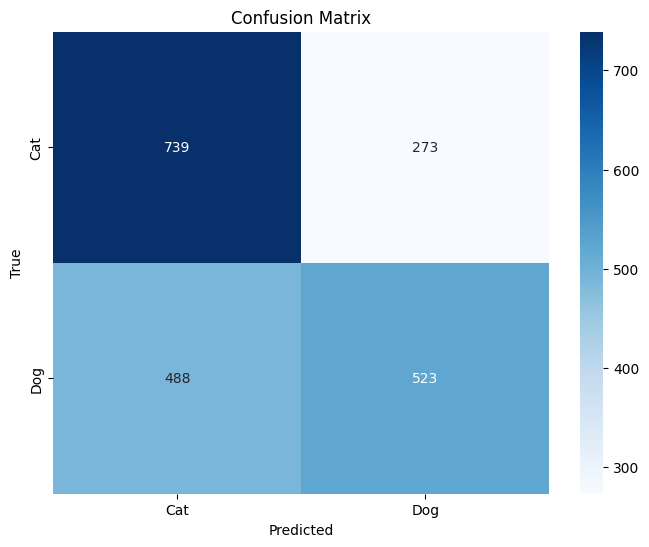

In [14]:
#Test the first gamma value trained model (gamma = 0.001)
pred1 = SVM.predict(features_test)

#Find the accuracy for the test data
accuracy = SVM.score(features_test, labels_test)
print("Accuracy = ",accuracy)

cm = confusion_matrix(labels_test, pred1)

# Set up the labels for the matrix
classes = ['Cat', 'Dog']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Accuracy =  0.6109738012852199


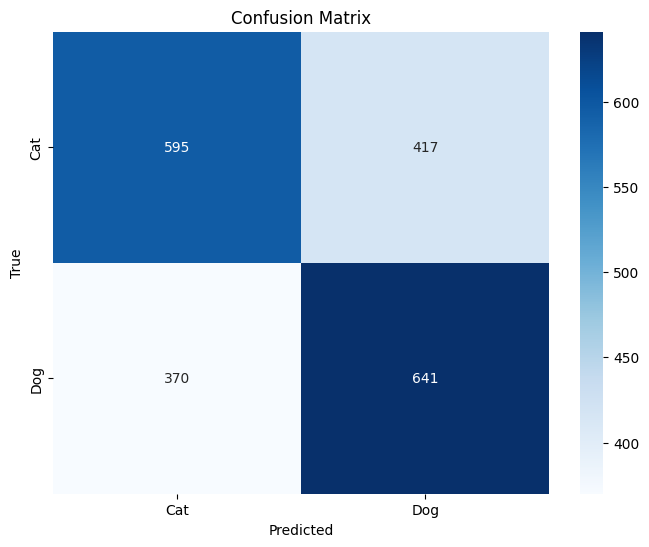

In [15]:
#Test the second gamma value trained model (gamma = 0.01)
pred2 = SVM2.predict(features_test)

#Find the accuracy for the test data
accuracy = SVM2.score(features_test, labels_test)
print("Accuracy = ",accuracy)

cm = confusion_matrix(labels_test, pred2)

# Set up the labels for the matrix
classes = ['Cat', 'Dog']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Accuracy =  0.6089965397923875


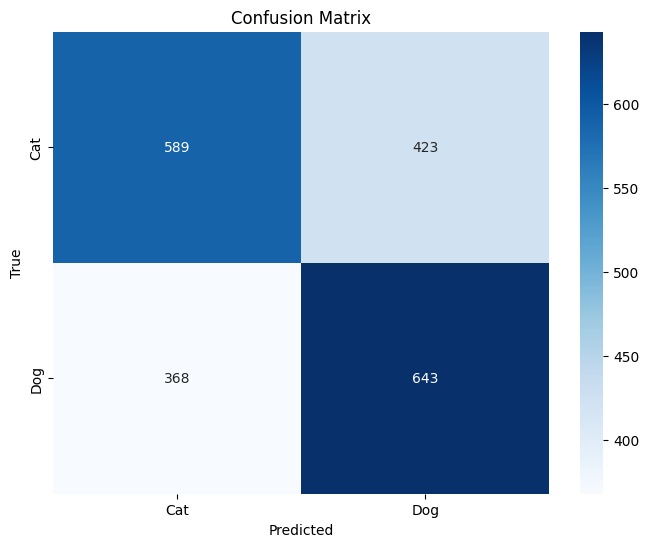

In [16]:
#Test the third gamma value trained model (gamma = 0.1)
pred3 = SVM3.predict(features_test)

#Find the accuracy for the test data
accuracy = SVM3.score(features_test, labels_test)
print("Accuracy = ",accuracy)

cm = confusion_matrix(labels_test, pred3)

# Set up the labels for the Confusion matrix
classes = ['Cat', 'Dog']

#Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Some of the ethical issues that can arise from the practices and processes of this model are as follows:
1. The model may be biased towards a specific color, hence breed of dogs and cats. It might classify dogs of a certain color as cats based on the previous learned features from cats of the same color. This may lead to discrimination against dogs and/or cats of a certain color, and in turn their breed. This may cause reduced attention towards animals on the other end of the classification who were not correctly classifier, when it comes to using the model for medical industry or other cares. 

**Bibliography**

For information on Scikit learn's SVM module, its parameters, and how to implement grid search using different C and gamma values. 
https://scikit-learn.org/stable/modules/svm.html#:~:text=Support%20vector%20machines%20(SVMs)%20are,Effective%20in%20high%20dimensional%20spaces.

For information on when to use SVM vs SVC:
https://rutgers.instructure.com/courses/243699/files?preview=36000051

For Python syntax and SVM clarifications:
https://chat.openai.com/